### import libraries

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.svm import SVR  

from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp

import pickle

%matplotlib inline

### import dataset

The `insurance.csv` dataset contains 1338 observations (rows) and 7 features (columns). <br>
The dataset contains 4 numerical features (age, bmi, children and expenses) and 3 nominal features (sex, smoker and region)

In [29]:
data = pd.read_csv('insurance.csv')

## Data Exploration

In [30]:
data.head(5)

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [31]:
data.tail(5)

,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [32]:
data.sample(5)

,age,sex,bmi,children,smoker,region,expenses
77,21,male,35.5,0,no,southeast,1532.47
488,44,female,38.1,0,yes,southeast,48885.14
572,30,female,43.1,2,no,southeast,4753.64
514,39,male,28.3,1,yes,southwest,21082.16
657,27,male,33.2,2,no,northwest,4058.71


In [33]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'expenses'], dtype='object')

### Exploratory Data  Analysis

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [35]:
data.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


## Data Cleaning
Check for NaN values in the dataset

In [36]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

columns and their contents

In [37]:
for col in data.columns:
    if data[col].dtype == 'object':
        print(col, ':', data[col].unique())
    else:
        print(col, ':', data[col].nunique())

age : 47
sex : ['female' 'male']
bmi : 275
children : 6
smoker : ['yes' 'no']
region : ['southwest' 'southeast' 'northwest' 'northeast']
expenses : 1337


## Feature Engineering

### Categorical to Numerical Encoding

In [38]:
le = LabelEncoder()

data['children'] = le.fit_transform(data['children'])
data['smoker'] = le.fit_transform(data['smoker'])

In [39]:
ohe = OneHotEncoder() 

data['sex'] = ohe.fit_transform(data[['sex']]).toarray()

regional_area = pd.DataFrame(ohe.fit_transform(data[['region']]).toarray()[:,:3], columns = ['SW', 'SE', 'NW'])
data = pd.concat([data.iloc[:,:6], regional_area, data['expenses']], axis = 1)

## Analytics and Visualization

In [40]:
data.sample(3)

,age,sex,bmi,children,smoker,region,SW,SE,NW,expenses
557,34,0.0,34.2,0,0,southeast,0.0,0.0,1.0,3935.18
851,61,0.0,32.3,2,0,northwest,0.0,1.0,0.0,14119.62
420,64,0.0,33.9,0,1,southeast,0.0,0.0,1.0,46889.26


### Statistical Analysis

In [41]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'SW', 'SE', 'NW',
       'expenses'],
      dtype='object')

In [42]:
for i in range(len(data.columns)-1):
    if data.columns[i] == 'region':
        continue
        
    print(data.columns[i])
    
    #for numerical-numerical
    if data.columns[i] in ['age', 'bmi']:
        
        pearson_coef, p_val = stats.pearsonr(data[data.columns[i]], data['expenses'])
        print('Pearson Coefficient :',pearson_coef,'\nP Value :',p_val,'\n')
        
        spearman_coef, p_val = stats.spearmanr(data[data.columns[i]], data['expenses'])
        print('Spearman Coefficient :',spearman_coef,'\nP Value :',p_val,'\n\n')
        
    #fot numerical-categorical    
    else:
        #one-way ANOVA
        F, p = stats.f_oneway(data[data.columns[i]],data['expenses'])
        print('F-Statistic=%.3f, p=%.3f\n\n' % (F, p))
        

age
Pearson Coefficient : 0.29900819228508274 
P Value : 4.886695589992816e-29 

Spearman Coefficient : 0.5343921337718459 
P Value : 1.130692027803638e-99 


sex
F-Statistic=1606.587, p=0.000


bmi
Pearson Coefficient : 0.198576255018932 
P Value : 2.301828073512984e-13 

Spearman Coefficient : 0.1194188536346528 
P Value : 1.1879756959712592e-05 


children
F-Statistic=1606.441, p=0.000


smoker
F-Statistic=1606.657, p=0.000


SW
F-Statistic=1606.648, p=0.000


SE
F-Statistic=1606.648, p=0.000


NW
F-Statistic=1606.640, p=0.000




In [43]:
data.corr()

,age,sex,bmi,children,smoker,SW,SE,NW,expenses
age,1.000000,0.020856,0.109341,0.042469,-0.025019,0.002475,-0.000407,-0.011642,0.299008
sex,0.020856,1.000000,-0.046380,-0.017163,-0.076185,0.002425,0.011156,-0.017117,-0.057292
bmi,0.109341,-0.046380,1.000000,0.012645,0.003968,-0.138091,-0.135992,0.270144,0.198576
children,0.042469,-0.017163,0.012645,1.000000,0.007673,-0.022808,0.024806,-0.023066,0.067998
smoker,-0.025019,-0.076185,0.003968,0.007673,1.000000,0.002811,-0.036945,0.068498,0.787251
SW,0.002475,0.002425,-0.138091,-0.022808,0.002811,1.000000,-0.320177,-0.345561,0.006349
SE,-0.000407,0.011156,-0.135992,0.024806,-0.036945,-0.320177,1.000000,-0.346265,-0.039905
NW,-0.011642,-0.017117,0.270144,-0.023066,0.068498,-0.345561,-0.346265,1.000000,0.073982
expenses,0.299008,-0.057292,0.198576,0.067998,0.787251,0.006349,-0.039905,0.073982,1.000000


### Plot Features vs 'expenses'

In [44]:
def numerical(num):
    sns.scatterplot(x=data[num], y = data['expenses'])
    plt.xlabel(num)
    plt.ylabel('Expenses')
    plt.title('{n} vs Expenses'.format(n = num))
    plt.show()

In [46]:
 def categorical(depen_var):
        fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12,8))
        fig.suptitle('{c} vs {n}'.format(c = depen_var.upper(), n = 'Expenses'))
        
        sns.boxplot(ax=axes[0], x = data[depen_var], y = data['expenses'])
        axes[0].set_title('Boxplot')

        sns.barplot(ax=axes[1],  x = data[depen_var], y = data['expenses'])
        axes[1].set_title('Bar Chart')

        plt.show()

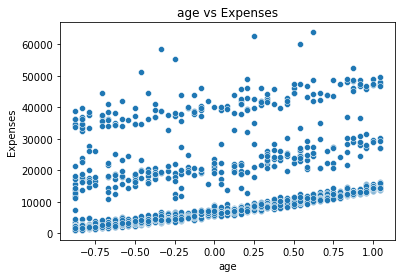

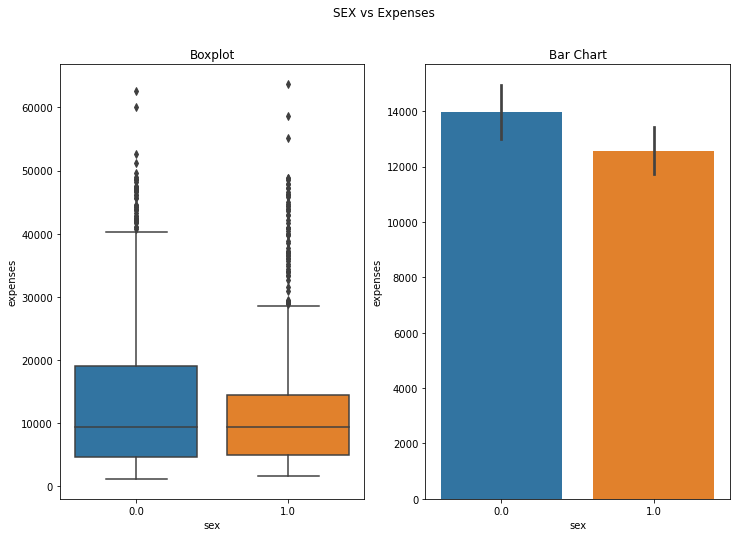

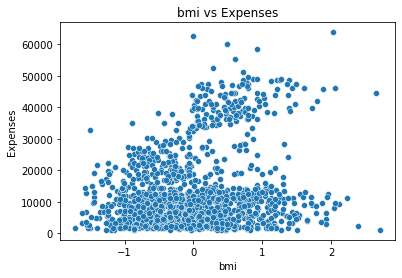

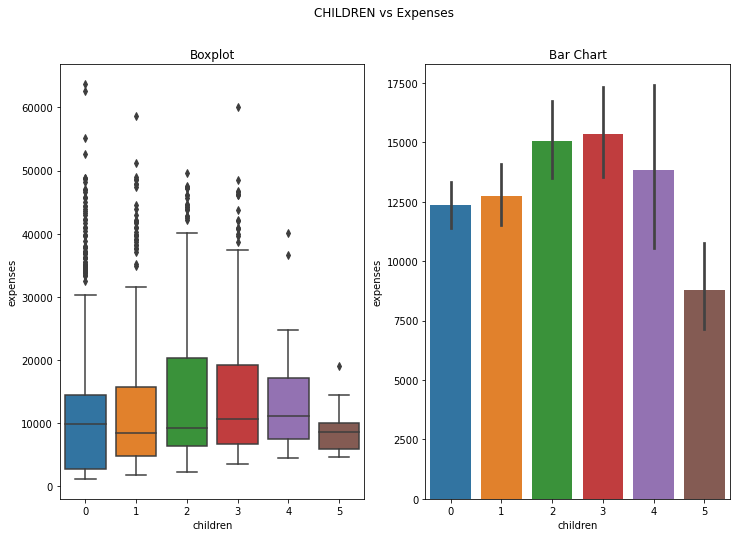

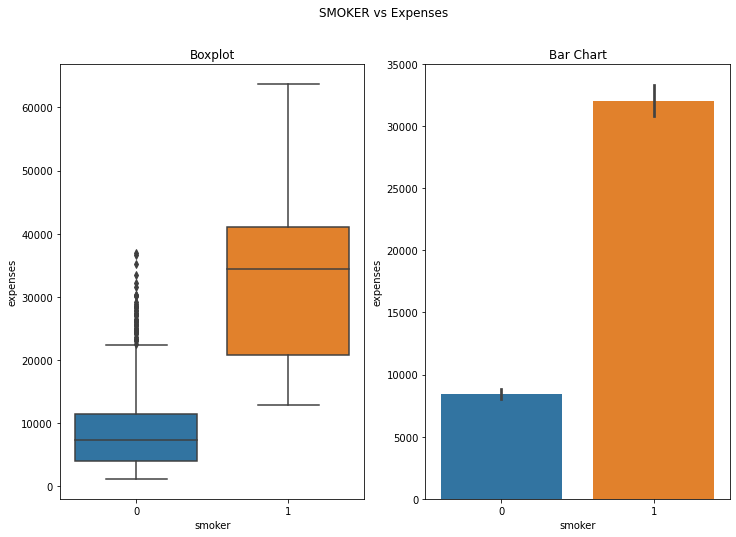

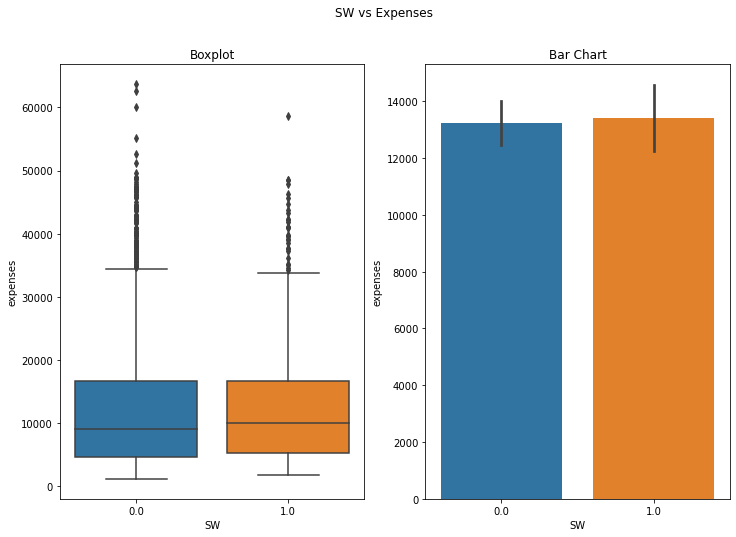

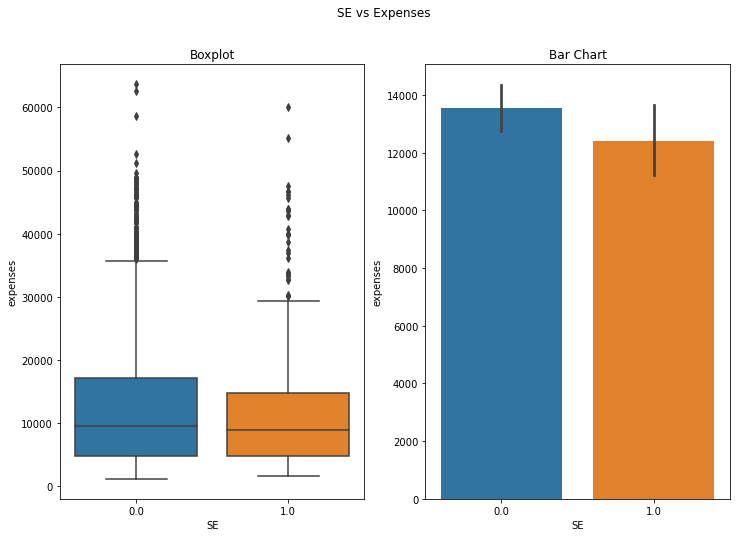

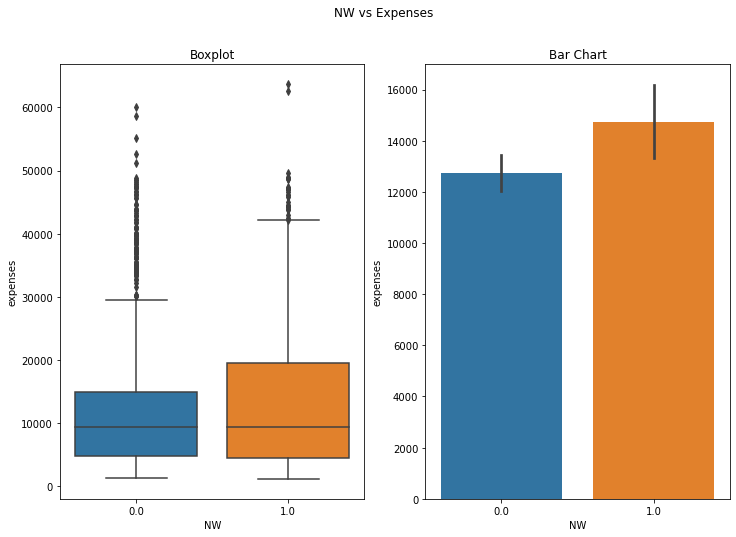

In [55]:
for feature in data.columns:
    if feature == 'expenses':
        continue
    elif feature in ['age', 'bmi']:
        numerical(feature)
    else:
        categorical(feature)

In [48]:
data.drop(columns = ['region'], inplace=True)

### Data Standardization

In [49]:
scaler = RobustScaler()

data[['age', 'bmi']] = scaler.fit_transform(data[['age', 'bmi']])

## Model Building

### train_test_split

In [60]:
y_data = data['expenses']
x_data = data.iloc[:,:8]

In [63]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15)

### Multiple Linear Regression

In [106]:
#regression object
mlr = LinearRegression()

#training the model
mlr.fit(x_train, y_train)

#predict values
pred_mlr = mlr.predict(x_test)

### Polynomial Regression

In [107]:
poly_reg = PolynomialFeatures(degree=2)
x_poly_data  = poly_reg.fit_transform(x_data)
x_poly_train, x_poly_test = train_test_split(x_poly_data, test_size = 0.15)


lin_reg2 = LinearRegression()
lin_reg2.fit(x_poly_train,y_train)
 
pred_poly = lin_reg2.predict(x_poly_test)

### Ridge Regression

In [108]:
RR = Ridge(alpha=0.01)

RR.fit(x_poly_train, y_train)

yhat_ridge = RR.predict(x_poly_test)

 #### tune hyperparameters (alpha) for Ridge Regression


In [109]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [110]:
grid = dict()
grid['alpha'] = [0.01, 0.03, 0.1, 0.3, 1]
search = GridSearchCV(RR, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
results=search.fit(x_data, y_data)
print('Best Estimate for Hyper Parameter Tuning : ', str(results.best_estimator_))
best_alpha_str = str(results.best_estimator_)
best_alpha = float(best_alpha_str[12:16])

Best Estimate for Hyper Parameter Tuning :  Ridge(alpha=0.01)


In [111]:
#final Ridge Regression model:

RR = Ridge(alpha = best_alpha)
RR.fit(x_poly_train, y_train)
pred_ridge = RR.predict(x_poly_test)

### Decision Tree Regressor

In [71]:
from sklearn.tree import DecisionTreeRegressor

In [112]:
dec_tree_reg = DecisionTreeRegressor(max_depth=5, random_state=13)  
dec_tree_reg.fit(x_train, y_train) 
pred_dec_tree = dec_tree_reg.predict(x_test)

### Random Forest Regressor

In [113]:
from sklearn.ensemble import RandomForestRegressor

In [118]:
rand_forr_reg = RandomForestRegressor(n_estimators=400, max_depth=5, random_state=13)  
rand_forr_reg.fit(x_train, y_train)
pred_rand_forr = rand_forr_reg.predict(x_test)

## Evaluation Metrics

In [127]:
def evaluate(estimator, pred_val):
    if estimator == poly:
        x = PolynomialFeatures(degree=2).fit_transform(x_data)
    else:
        x = x_data
    r2 = r2_score(y_test, pred_rand_forest_reg)
    rmse = np.sqrt(mean_squared_error(y_test, pred_val))
    score = cross_val_score(estimator, x, y_data, cv=4).mean()
    return r2, rmse, score

In [128]:
#Multpiple Linear Regression
mlr_r2, mlr_rmse, mlr_cvscore = evaluate(mlr, pred_mlr)
print(mlr_r2, mlr_rmse, mlr_cvscore)

0.8690217392624761 5875.946107682473 0.7460581522866252


In [133]:
#Polynomial Regression
poly = LinearRegression()
poly_r2, poly_rmse, poly_cvscore = evaluate(poly, pred_poly)
print(poly_r2, poly_rmse, poly_cvscore)

0.8690217392624761 12314.26895322122 0.8354338118410909


In [129]:
#Ridge Regression
ridge_r2, ridge_rmse, ridge_cvscore = evaluate(RR, pred_ridge)
print(ridge_r2, ridge_rmse, ridge_cvscore)

0.8690217392624761 12314.237529782913 0.7460581967107554


In [137]:
#Decision Tree Regressor
dec_tree_r2, dec_tree_rmse, dec_tree_cvscore = evaluate(dec_tree_reg, pred_dec_tree)
print(dec_tree_r2, dec_tree_rmse, dec_tree_cvscore)

0.8690217392624761 4665.932853359235 0.8313315872058668


In [132]:
#Random Forest Regressor
ran_r2, ran_rmse, ran_cvscore = evaluate(random_forest_reg, pred_rand_forest_reg)
print(ran_r2, ran_rmse, ran_cvscore)

0.8690217392624761 4428.6913541287095 0.8544990867810639


### Comparing Model perfomances

In [138]:
r2_scores = [mlr_r2, poly_r2, ridge_r2, dec_tree_r2, ran_r2]
rmse_scores = [mlr_rmse, poly_rmse, ridge_rmse, dec_tree_rmse, ran_rmse]
cross_val_scores  = [mlr_cvscore, poly_cvscore, ridge_cvscore, dec_tree_cvscore, ran_cvscore]

In [139]:
models_comparison = pd.DataFrame([r2_scores, rmse_scores, cross_val_scores], 
                                 columns = ['Multiple Linear Regression', 'Polynomial Regression', 'Ridge Regression', 
                                          'Decision Tree Regressor', 'Random Forest Regressor'],
                                 index = ['R2 score', 'RMSE score', 'Cross Validation Score'])

In [140]:
models_comparison

,Multiple Linear Regression,Polynomial Regression,Ridge Regression,Decision Tree Regressor,Random Forest Regressor
R2 score,0.869022,0.869022,0.869022,0.869022,0.869022
RMSE score,5875.946108,12314.268953,12314.237530,4665.932853,4428.691354
Cross Validation Score,0.746058,0.835434,0.746058,0.831332,0.854499


 #### apparantly, the Random Forest Regressor is the best fit to the model and hence, we shall us it for our final model

### final model: RandomTreeRegressor

In [141]:
#training the model with all data available
random_forest_reg.fit(x_data, y_data)

RandomForestRegressor(max_depth=5, n_estimators=400, random_state=13)